In [3]:
import torch
from mo_bayes_opt import MultiObjectiveBO

def joint_objective(x):
    x1 = x[:, 0]
    x2 = x[:, 1]
    interaction = torch.sin(5 * torch.pi * x1 * x2)
    f1 = ((x[:, :3] * torch.sin(3 * torch.pi * x[:, :3])).sum(dim=-1) + 0.5 * interaction)
    f2 = (((1 - x[:, 3:]) * torch.cos(3 * torch.pi * x[:, 3:])).sum(dim=-1) - 0.3 * interaction)
    return torch.stack([f1, f2], dim=-1)

input_dim = 2
output_dim = 2

bo = MultiObjectiveBO(
    objective_fn=joint_objective,
    input_dim=2,
    bounds=torch.tensor([[0.0] * input_dim, [1.0] * input_dim]),
    ref_point=torch.tensor([-1.0] * output_dim),
    strategy="qEHVI",
    use_adaptive_noise=False,
    save_models=True,
)
hypervolumes = bo.run(num_repeats=10, num_queries=25, q=4, log_path="log.hdf5")


Trial 0


100%|██████████| 25/25 [02:19<00:00,  5.57s/it]



Trial 1


100%|██████████| 25/25 [03:06<00:00,  7.46s/it]



Trial 2


100%|██████████| 25/25 [02:32<00:00,  6.11s/it]



Trial 3


100%|██████████| 25/25 [03:19<00:00,  8.00s/it]



Trial 4


100%|██████████| 25/25 [02:45<00:00,  6.62s/it]



Trial 5


100%|██████████| 25/25 [02:14<00:00,  5.38s/it]



Trial 6


100%|██████████| 25/25 [22:07<00:00, 53.09s/it]   



Trial 7


100%|██████████| 25/25 [02:58<00:00,  7.12s/it]



Trial 8


100%|██████████| 25/25 [02:47<00:00,  6.68s/it]



Trial 9


100%|██████████| 25/25 [03:12<00:00,  7.70s/it]


In [4]:
import botorch
print(botorch.__version__)


0.14.0


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hypervolume_evolution(hypervolumes):
    hypervolumes = np.array(hypervolumes)  # shape: [num_repeats, num_queries]

    mean_hv = np.mean(hypervolumes, axis=0)
    std_hv = np.std(hypervolumes, axis=0)

    steps = np.arange(hypervolumes.shape[1])

    plt.figure(figsize=(4, 2))
    for i in range(hypervolumes.shape[0]):
        plt.plot(steps, hypervolumes[i], color='gray', alpha=0.2, linewidth=1)

    plt.plot(steps, mean_hv, color='blue', label='Mean Hypervolume', linewidth=2)
    plt.fill_between(steps, mean_hv - std_hv, mean_hv + std_hv, color='blue', alpha=0.2, label='±1 Std. Dev')

    plt.xlabel('Number of Queries')
    plt.ylabel('Hypervolume')
    plt.title('Hypervolume Evolution over Repeats')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.show()

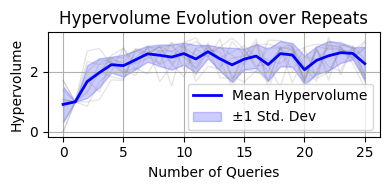

In [6]:
# 绘图
plot_hypervolume_evolution(hypervolumes)
plt.savefig('hypervolume_evolution.png', dpi=300)

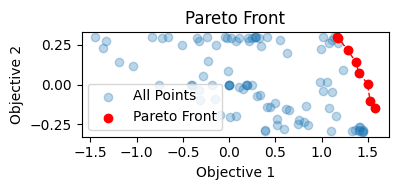

In [7]:
import numpy as np
from mo_bayes_opt.utils.visualization import plot_pareto

logger = bo.logger
history = logger.get_all_data()
train_x = torch.cat([data["x"] for data in history[0]], dim=0)  # shape: (101, 2)
train_y = torch.cat([data["y"] for data in history[0]], dim=0)  # shape: (101, 2)
plot_pareto(train_y)

In [10]:
logger = bo.logger
history = logger.get_all_data()
models = history[0][-1]["models"]
# 假设你已经训练好最后一个模型：
model1 = models[0]  # or model2
model2 = models[1]

In [11]:
def predict_matrix(model, X, Y):
    predict_x = torch.concat([X.flatten().unsqueeze(-1), Y.flatten().unsqueeze(-1)], dim=-1)
    pred_mean, pred_std = model.predict_mean_std(predict_x)
    pred_mean = pred_mean.reshape(X.shape[0], X.shape[1])
    pred_std = pred_std.reshape(X.shape[0], X.shape[1])
    return pred_mean, pred_std

test_x = torch.linspace(0, 1, 100).unsqueeze(-1).repeat(1, input_dim)  # 100 个点
X, Y = torch.meshgrid(test_x[:, 0], test_x[:, 1], indexing='ij')
Z = joint_objective(torch.stack([X.flatten(), Y.flatten()], dim=-1)).reshape(X.shape[0], X.shape[1], -1)

pred1_mean, pred1_std = predict_matrix(model1, X, Y)
pred2_mean, pred2_std = predict_matrix(model2, X, Y)

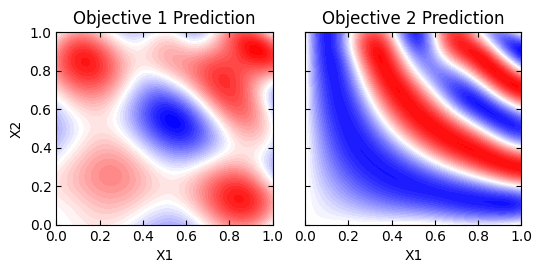

In [12]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))
plt.subplots_adjust(wspace=0.15)
# 绘制第一个目标函数的预测
axs[0].contourf(X.numpy(), Y.numpy(), pred1_mean.numpy(), levels=50, cmap='bwr')
axs[0].set_title('Objective 1 Prediction')
axs[0].set_xlabel('X1')
axs[0].set_ylabel('X2')
# 绘制第二个目标函数的预测
axs[1].contourf(X.numpy(), Y.numpy(), pred2_mean.numpy(), levels=50, cmap='bwr')
axs[1].set_title('Objective 2 Prediction')
axs[1].set_xlabel('X1')
axs[1].set_ylabel('X2')
# plt.tight_layout()

for ax in axs.flatten():
    ax.tick_params(direction='in', top=True, right=True)
    ax.label_outer()

plt.savefig('predictions.png')